# Task 4: Portfolio Optimization Based on Forecasts
### This notebook will:

1. Combine historical and forecasted data for each asset (TSLA, BND, SPY).
2. Compute expected returns and volatility for each asset based on forecasted prices.
3. Optimize the portfolio allocation to maximize the Sharpe Ratio (risk-adjusted return).
4. Analyze the optimized portfolio’s risk, returns, and volatility, and visualize the cumulative performance.

### Import necessary libraries

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Define paths to data and models

In [2]:
# Define paths to data and models
os.chdir(r'c:\users\ermias.tadesse\10x\Predictive-Analysis-And-Modeling')
data_folder_path = 'Data/'
models_folder_path = 'Models/'

### Load Historical Data and Forecasts
We’ll load historical data and append forecasted data to calculate expected returns and volatility for each asset.

In [4]:
# Define tickers
tickers = ['TSLA', 'BND', 'SPY']

# Dictionary to store historical and forecasted data
data = {}

for ticker in tickers:
    # Load historical data
    processed_data_path = os.path.join(data_folder_path, 'processed', f'{ticker}_train.csv')
    historical_data = pd.read_csv(processed_data_path, parse_dates=['Date'], index_col='Date')
    
    # Load forecasted data generated in Task 3
    forecast_path = os.path.join(data_folder_path, 'processed', f'{ticker}_forecast.csv')
    forecast_data = pd.read_csv(forecast_path, parse_dates=['Date'], index_col='Date')
    
    # Concatenate historical and forecasted data
    combined_data = pd.concat([historical_data['Close'], forecast_data['Forecast']], axis=0)
    data[ticker] = combined_data

    # Display the last few rows of combined data
    print(f"\n{ticker} Data (Last 5 Rows):\n", combined_data.tail())



TSLA Data (Last 5 Rows):
 Date
2024-02-22 00:00:00+00:00    316.41122
2024-02-23 00:00:00+00:00    316.56805
2024-02-26 00:00:00+00:00    316.72305
2024-02-27 00:00:00+00:00    316.87634
2024-02-28 00:00:00+00:00    317.02798
dtype: float64

BND Data (Last 5 Rows):
 Date
2024-02-22 00:00:00+00:00    70.71255
2024-02-23 00:00:00+00:00    70.71100
2024-02-26 00:00:00+00:00    70.70946
2024-02-27 00:00:00+00:00    70.70793
2024-02-28 00:00:00+00:00    70.70642
dtype: float64

SPY Data (Last 5 Rows):
 Date
2024-02-22 00:00:00+00:00    419.24100
2024-02-23 00:00:00+00:00    419.27320
2024-02-26 00:00:00+00:00    419.30518
2024-02-27 00:00:00+00:00    419.33694
2024-02-28 00:00:00+00:00    419.36838
dtype: float64


### Calculate Daily Returns and Expected Annual Return
We’ll calculate daily returns based on forecasted prices and use them to compute the expected annual return for each asset.

In [5]:
# Calculate daily returns for each asset
returns = pd.DataFrame({ticker: data[ticker].pct_change().dropna() for ticker in tickers})

# Calculate expected annual return for each asset
annual_returns = returns.mean() * 252  # Assuming 252 trading days

# Display annual returns
print("Expected Annual Returns:\n", annual_returns)


Expected Annual Returns:
 TSLA    0.774170
BND    -0.038926
SPY     0.084380
dtype: float64


###  Calculate Covariance Matrix
The covariance matrix of returns will help us understand the co-movement of asset prices, which is crucial for portfolio risk management

In [6]:
# Calculate the covariance matrix for the asset returns
cov_matrix = returns.cov() * 252  # Annualized covariance

# Display the covariance matrix
print("Annualized Covariance Matrix:\n", cov_matrix)


Annualized Covariance Matrix:
           TSLA       BND       SPY
TSLA  0.399901  0.004166  0.069983
BND   0.004166  0.004259  0.003021
SPY   0.069983  0.003021  0.046543


### Define Portfolio Optimization Function
We’ll define a function to calculate the portfolio’s expected return and volatility based on asset weights. This function will also compute the Sharpe Ratio to identify the optimal weight allocation.

In [7]:
# Define the portfolio performance function
def portfolio_performance(weights, annual_returns, cov_matrix):
    returns = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = returns / volatility
    return returns, volatility, sharpe_ratio


### Optimize Portfolio to Maximize Sharpe Ratio
Using scipy.optimize.minimize, we’ll find the asset weight allocation that maximizes the Sharpe Ratio, indicating the best risk-adjusted return.

In [8]:
# Define the objective function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, annual_returns, cov_matrix):
    return -portfolio_performance(weights, annual_returns, cov_matrix)[2]

# Constraints: Weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for weights (0 <= weight <= 1 for each asset)
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess (equal distribution)
initial_weights = [1/len(tickers)] * len(tickers)

# Perform optimization
result = minimize(negative_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimized_weights = result.x
print("Optimized Weights:\n", dict(zip(tickers, optimized_weights)))


Optimized Weights:
 {'TSLA': 0.9999999999999999, 'BND': 5.551115123125783e-17, 'SPY': 5.551115123125783e-17}


### Analyze Optimized Portfolio Performance
Calculate the expected return, volatility, and Sharpe Ratio of the optimized portfolio.

In [9]:
# Calculate portfolio performance metrics with optimized weights
opt_returns, opt_volatility, opt_sharpe = portfolio_performance(optimized_weights, annual_returns, cov_matrix)

# Display portfolio metrics
print(f"Optimized Portfolio Performance:\n- Expected Return: {opt_returns:.2%}\n- Volatility: {opt_volatility:.2%}\n- Sharpe Ratio: {opt_sharpe:.2f}")


Optimized Portfolio Performance:
- Expected Return: 77.42%
- Volatility: 63.24%
- Sharpe Ratio: 1.22


### Visualize Portfolio Performance
Plot the cumulative returns for each asset and the optimized portfolio to compare performance.

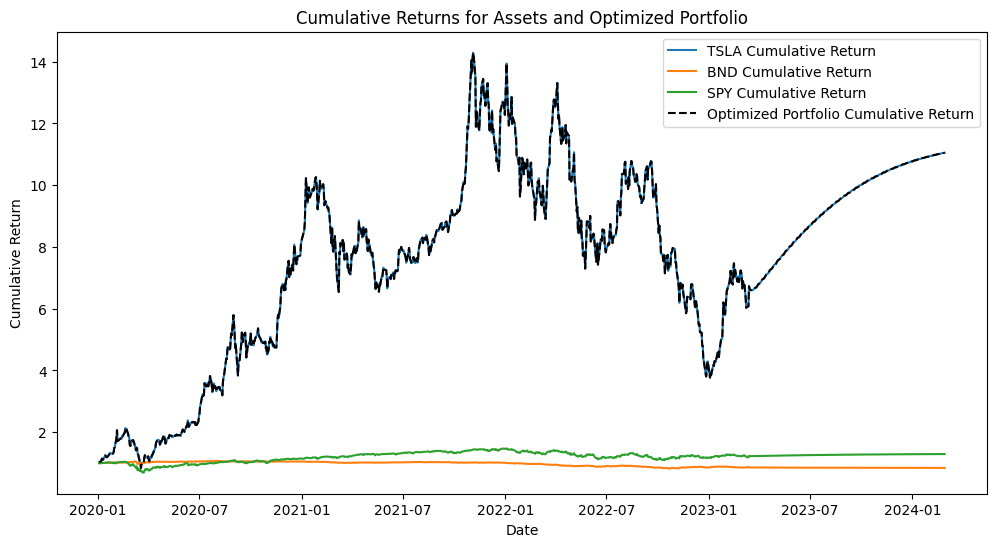

In [10]:
# Calculate cumulative returns for each asset and optimized portfolio
cumulative_returns = (1 + returns).cumprod()

# Calculate portfolio cumulative returns based on optimized weights
cumulative_portfolio_returns = (cumulative_returns * optimized_weights).sum(axis=1)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns[ticker], label=f'{ticker} Cumulative Return')
plt.plot(cumulative_portfolio_returns, label='Optimized Portfolio Cumulative Return', color='black', linestyle='--')
plt.title('Cumulative Returns for Assets and Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
